# Natural language processing (NLP) 
ability of a computer program to understand human language as it is spoken and written

In [146]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os

In [147]:
# get text dataset
dir_path = 'nlp_getting_started'
os.listdir(dir_path)

['sample_submission.csv', 'test.csv', 'train.csv']

In [148]:
train_df = pd.read_csv(os.path.join(dir_path,'train.csv'))
test_df = pd.read_csv(os.path.join(dir_path,'test.csv'))
print(train_df.shape)
train_df.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [149]:
#split data to validation sets
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df['text'].to_numpy(), 
                                                                            train_df['target'].to_numpy(),
                                                                            test_size=.1,
                                                                            random_state=42)
train_sentences.shape, val_sentences.shape, train_labels.shape, val_labels.shape                                                                       

((6851,), (762,), (6851,), (762,))

In [150]:
print(train_sentences[:5], train_labels[:5])

["'McFadden Reportedly to Test Hamstring Thursday' via @TeamStream http://t.co/jWq4KvJH2j"
 'w--=-=-=-[ NEMA warns Nigerians to prepare for drought http://t.co/5uoOPhSqU3'
 "When I was cooking earlier I got electrocuted some crucial ?????? now I'm psychic lol"
 "I'm On Fire.  http://t.co/WATsmxYTVa"
 "More than 40 families affected by the fatal outbreak of Legionnaires' disease in Edinburgh are to sue two comp... http://t.co/vsoXioOy78"] [0 1 0 0 1]


### Tokenization vs Embedding
- Tokenization : i use python -> 0 1 2 -> onehot [1,0,0],[0,1,0],[0,0,1]
- Embedding : i use python -> [0.49, 0.005, 0.015] represent of relationships (can set limit size)

<p align=center><img src="https://miro.medium.com/max/1400/1*sAJdxEsDjsPMioHyzlN3_A.png" width=600px/></p>

In [151]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=None, # how many vocabulary in all data
                                    standardize='lower_and_strip_punctuation', # just like number [0..255] -> [0..1]
                                    split = 'whitespace',
                                    ngrams=None, # how many word in group (None = just single word not to group)
                                    output_mode='int', # how output look like (int = any specific int number)
                                    output_sequence_length=50 ) # how long vector of sentence (None = as you can)
                                    # pad_to_max_tokens = True  ,pad 0 of sentence as the same shape as longest sentence( Not valid if using max_tokens=None)

In [152]:
# find the average number of tokens (words) in the traning
round(np.sum( [len(sentences.split()) for sentences in train_sentences]) / len(train_sentences))

15

In [153]:
#setup text vectorization variabel
max_vocab_length = 10000
max_length = 15 # first 15 word for each sentences

text_vectorizer = TextVectorization(max_tokens=max_vocab_length, 
                                    output_mode='int', 
                                    output_sequence_length=max_length)

In [154]:
#fit the text vectorizer to the training sets
text_vectorizer.adapt(train_sentences)

In [155]:
# see what it look like?
sample_sentence = 'There a some word here, i dont know'
print(text_vectorizer([sample_sentence]))

tf.Tensor(
[[  75    3   77 1455  127    8   64   99    0    0    0    0    0    0
     0]], shape=(1, 15), dtype=int64)


In [156]:
# get vocabulary
word_in_vocab = text_vectorizer.get_vocabulary()
word_in_vocab[:10] , len(word_in_vocab)

(['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'], 10000)

> order by most common word

UNK = unknow token (word that out of max_tokens)

### Creating an Embedding 
- input_dim = size of out vocaburary
- output_dim = size of vector / [0.45, 0.34 , ... ,n]
- input_lenght = lenght of sentences 

In [157]:
from tensorflow.keras import layers

# embedding just initial random weights and learn from data
embedding = layers.Embedding(input_dim= max_vocab_length, 
                             output_dim= 128 , 
                             input_length = max_length)

In [158]:
# turn index from vectorizer to embed
print(sample_sentence)
sample_embed = embedding(text_vectorizer([sample_sentence]))
print('shape :',sample_embed.shape)
print(sample_embed[0,:5,:5].numpy())

There a some word here, i dont know
shape : (1, 15, 128)
[[-0.01948813 -0.03012013 -0.04634937 -0.04255333 -0.00452403]
 [-0.02627006  0.00849152  0.03070411  0.04503476  0.02668203]
 [-0.02189822  0.01844107 -0.03520787  0.02666353 -0.02444199]
 [-0.02467533 -0.00610204 -0.02113923 -0.02500092  0.02206217]
 [ 0.0016902   0.0104217   0.04259631 -0.04584226 -0.02605658]]


## Modeling with Varince Model

### Naive Bayes
predict the tag of a text. They calculate the probability of each tag for a given text and then output the tag with the highest one. using with **TF-IDF** formula to convert our word to numbers.

In [159]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

tfidf = TfidfVectorizer()

model_1 = MultinomialNB()
model_1.fit(tfidf.fit_transform(train_sentences), train_labels)

MultinomialNB()

In [160]:
baseline_score = model_1.score(tfidf.transform(val_sentences), val_labels)
print(f'baseline accuracy = {baseline_score*100:.2f}%')

baseline accuracy = 77.82%


In [192]:
y_preds = model_1.predict(tfidf.transform(val_sentences))
y_prob = model_1.predict_proba(tfidf.transform(val_sentences))
y_preds[:50:5]

array([0, 0, 1, 0, 0, 0, 1, 1, 0, 0], dtype=int64)

In [162]:
# create evaluation function
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_score(y_true, y_preds):
    accuracy = accuracy_score(y_true, y_preds)
    precision, recall, f1_score = precision_recall_fscore_support(y_true, y_preds, average='weighted')[:-1]
    evaluation_dict = {'accuracy':accuracy,'precision':precision,'recall':recall,'f1_score':f1_score}
    return evaluation_dict

In [163]:
baseline_result = evaluate_score(val_labels, y_preds)
baseline_result

{'accuracy': 0.7782152230971129,
 'precision': 0.792992256322435,
 'recall': 0.7782152230971129,
 'f1_score': 0.7703527809038113}

### Simple Dense Model

In [164]:
# GlobalAveragePooling1D
input_shape = (1,3,4)
x = tf.random.normal(input_shape)
y = tf.keras.layers.GlobalMaxPooling1D()(x)
print(f'''
{x}:{x.shape}
{y}:{y.shape}
''')


[[[-0.5687541   0.42188227  0.48720983 -0.7756028 ]
  [ 1.2014514   1.3573484   1.2616866   0.14994632]
  [ 1.492991    0.83395654  0.4605777   0.8468246 ]]]:(1, 3, 4)
[[1.492991  1.3573484 1.2616866 0.8468246]]:(1, 4)



In [165]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string) # 1 sentence at a time
x = text_vectorizer(inputs) # text to number
x = embedding(x) # number to embed
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding
outputs = layers.Dense(1, activation='sigmoid')(x) # binary output
model_2 = tf.keras.Model(inputs, outputs, name='model_2_dense')

In [166]:
model_2.summary()

Model: "model_2_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [167]:
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                metrics=['accuracy'])

hist_2 = model_2.fit(train_sentences,
                     train_labels, 
                     validation_data = (val_sentences, val_labels), 
                     epochs=5)

Epoch 1/5
215/215 [==============================] - 4s 16ms/step - loss: 0.6874 - accuracy: 0.6040 - val_loss: 0.6795 - val_accuracy: 0.6142
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.6689 - accuracy: 0.6446 - val_loss: 0.6635 - val_accuracy: 0.6312
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.6482 - accuracy: 0.6671 - val_loss: 0.6462 - val_accuracy: 0.6575
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.6253 - accuracy: 0.6944 - val_loss: 0.6285 - val_accuracy: 0.6811
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.6010 - accuracy: 0.7240 - val_loss: 0.6103 - val_accuracy: 0.7060


In [168]:
model_2_proba = model_2.predict(val_sentences).reshape(-1,)
model_2_proba[:5]

array([0.30430773, 0.3719131 , 0.44592562, 0.34913266, 0.4526522 ],
      dtype=float32)

In [169]:
y_preds_2 = np.round(model_2_proba)
y_preds_2[:40]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0.], dtype=float32)

In [170]:
model2_result = evaluate_score(val_labels, y_preds_2)
model2_result

{'accuracy': 0.7060367454068242,
 'precision': 0.7741872038074336,
 'recall': 0.7060367454068242,
 'f1_score': 0.6710350727334745}

Let's visualize what embedding layer learn

In [171]:
embed_weights =  model_2.layers[2].get_weights()[0]
embed_weights.shape

(10000, 128)

> 10000 vocab in 128 dimention

In [172]:
import io

out_v = io.open('vectors.tsv','w', encoding='utf-8')
out_m = io.open('metadata.tsv','w', encoding='utf-8')

for index, word in enumerate(word_in_vocab):
    if index == 0 :
        continue 
    vec = embed_weights[index] # 128 dimention vector
    out_v.write('\t'.join([str(x) for x in vec]) + '\n')
    out_m.write(word + '\n')

out_v.close()
out_m.close()

> then open in [Embedding Projector](https://projector.tensorflow.org/)

In [205]:
#LSTM
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(units=64, activation='tanh', return_sequences=True)(x) # if want stack RNN cell must retrub sequences
x = layers.LSTM(units=64, activation='tanh')(x)  # becuase RNN input is 3D
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='LSTM')

model_3.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm_11 (LSTM)              (None, 15, 64)            49408     
                                                                 
 lstm_12 (LSTM)              (None, 64)                33024     
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                              

In [206]:
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=['accuracy'])
hist_3 = model_3.fit(train_sentences,
                     train_labels, 
                     validation_data = (val_sentences, val_labels), 
                     epochs=5)

Epoch 1/5
215/215 [==============================] - 11s 25ms/step - loss: 0.1716 - accuracy: 0.9437 - val_loss: 0.7824 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 5s 24ms/step - loss: 0.0978 - accuracy: 0.9654 - val_loss: 0.8387 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 5s 24ms/step - loss: 0.0747 - accuracy: 0.9714 - val_loss: 0.9290 - val_accuracy: 0.7559
Epoch 4/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0582 - accuracy: 0.9755 - val_loss: 1.3178 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 6s 27ms/step - loss: 0.0545 - accuracy: 0.9750 - val_loss: 1.1879 - val_accuracy: 0.7612


In [207]:
model_3_proba = model_3.predict(val_sentences).reshape(-1,)
y_preds_3 = np.round(model_3_proba)
y_preds_3[:10]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1.], dtype=float32)

In [208]:
model3_result = evaluate_score(val_labels, y_preds_3)
model3_result

{'accuracy': 0.7611548556430446,
 'precision': 0.760697484078527,
 'recall': 0.7611548556430446,
 'f1_score': 0.7593734508428278}

In [209]:
#GRU
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(units=64, activation='tanh')(x) 
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name='GRU_model')

model_4.summary()

Model: "GRU_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru_3 (GRU)                 (None, 64)                37248     
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_______________________________________________

In [210]:
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=['accuracy'])
hist_4 = model_4.fit(train_sentences,
                     train_labels, 
                     validation_data = (val_sentences, val_labels), 
                     epochs=5)

Epoch 1/5
215/215 [==============================] - 6s 21ms/step - loss: 0.1656 - accuracy: 0.9288 - val_loss: 0.7477 - val_accuracy: 0.7598
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0738 - accuracy: 0.9737 - val_loss: 0.7895 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0601 - accuracy: 0.9764 - val_loss: 1.0110 - val_accuracy: 0.7572
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0510 - accuracy: 0.9768 - val_loss: 1.1757 - val_accuracy: 0.7520
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0449 - accuracy: 0.9815 - val_loss: 1.3481 - val_accuracy: 0.7415


In [211]:
model_4_proba = model_4.predict(val_sentences).reshape(-1,)
y_preds_4 = np.round(model_4_proba)
y_preds_4[:10]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1.], dtype=float32)

In [212]:
model4_result = evaluate_score(val_labels, y_preds_4)
model4_result

{'accuracy': 0.7414698162729659,
 'precision': 0.7433230225832096,
 'recall': 0.7414698162729659,
 'f1_score': 0.7420274863458916}

can use more with
- Bidirectonal RNN model
- Conv1D with GlobalMax1D

In [213]:
#compare result
result_df = pd.DataFrame({
    'baseline':baseline_result,
    'dense':model2_result,
    'LSTM':model3_result,
    'GRU':model4_result,}
).T
result_df

,accuracy,precision,recall,f1_score
baseline,0.778215,0.792992,0.778215,0.770353
dense,0.706037,0.774187,0.706037,0.671035
LSTM,0.761155,0.760697,0.761155,0.759373
GRU,0.741470,0.743323,0.741470,0.742027


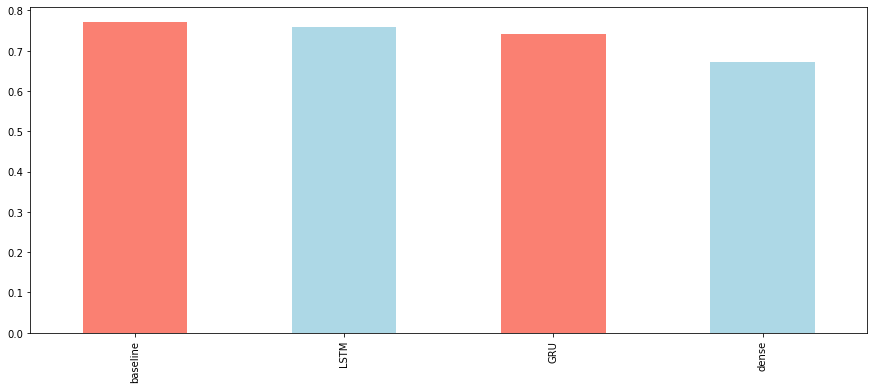

In [214]:
# order by f1 socre
result_df.sort_values('f1_score', ascending=False)['f1_score'].plot(kind='bar', figsize=(15,6), color=['salmon','lightblue']);

## Find the most wrong Predictions

In [217]:
val_df = pd.DataFrame({
    'text':val_sentences,
    'target':val_labels,
    'pred':y_preds_3,
    'pred_proba':model_3_proba
})

val_df.head()

,text,target,pred,pred_proba
0,So you have a new weapon that can cause un-ima...,1,0.0,0.000948
1,The f$&amp;@ing things I do for #GISHWHES Just...,0,0.0,0.055981
2,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1,0.0,0.000870
3,Aftershock back to school kick off was great. ...,0,0.0,0.000314
4,in response to trauma Children of Addicts deve...,0,1.0,0.995494


In [224]:
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values('pred_proba', ascending=False)
most_wrong.head(10) # false positive

,text,target,pred,pred_proba
291,@DavidCovucci We can't because a sinkhole swal...,0,1.0,0.999934
458,Today was trauma on top of trauma on top of t...,0,1.0,0.999934
428,HereÛªs how media in Pakistan covered the cap...,0,1.0,0.999926
347,Survivors of Shanghai Ghetto reunite after 70 ...,0,1.0,0.999907
197,@NWSPocatello BG-16: So far brunt of storm jus...,0,1.0,0.999900
261,dogs Lightning reshapes rocks at the atomic le...,0,1.0,0.999885
454,Irony just died a thousand deaths! ???? http:/...,0,1.0,0.999868
413,@mfalcon21 go look. Just blew it up w atomic b...,0,1.0,0.999641
117,Dust devil maintenance fee - buy up la rotary ...,0,1.0,0.999585
556,My @Quora answer to Why do my answers get coll...,0,1.0,0.999493


In [230]:
most_wrong.tail(10) # false negative

,text,target,pred,pred_proba
439,New Giant Flames (GIANT FULL BLACK PANTOFEL) i...,1,0.0,0.000212
534,@NRO Except when ordered not to carry unauthor...,1,0.0,0.000206
345,burned 129 calories doing 24 minutes of Walkin...,1,0.0,0.000167
441,TRUCK ABLAZE : R21. VOORTREKKER AVE. OUTSIDE O...,1,0.0,0.000150
6,my favorite lady came to our volunteer meeting...,1,0.0,0.000145
399,To All The Meat-Loving Feminists Of The World ...,1,0.0,0.000123
674,@TemecaFreeman GM! I pray any attack of the en...,1,0.0,0.000120
593,all that panicking made me tired ;__; i want t...,1,0.0,0.000113
445,Two hours to get to a client meeting. Whirlwin...,1,0.0,0.000112
498,Businesses are deluged with invoices. Make you...,1,0.0,0.000103


## Making Prediction on testing set

In [252]:
prediction = model_1.predict(tfidf.transform(test_df['text']))
class_ = ['Not diaster','diaster!!']
prediction = [class_[pred] for pred in prediction]
test_df['prediction'] = prediction
test_df = test_df[['text','prediction']]
test_df.head(10)

,text,prediction
0,Just happened a terrible car crash,diaster!!
1,"Heard about #earthquake is different cities, s...",Not diaster
2,"there is a forest fire at spot pond, geese are...",diaster!!
3,Apocalypse lighting. #Spokane #wildfires,diaster!!
4,Typhoon Soudelor kills 28 in China and Taiwan,diaster!!
5,We're shaking...It's an earthquake,diaster!!
6,They'd probably still show more life than Arse...,Not diaster
7,Hey! How are you?,Not diaster
8,What a nice hat?,Not diaster
9,Fuck off!,Not diaster


## The speed/score tradeoff
what model is fast and higt f1_score

In [308]:
import time

t1 = time.perf_counter()
model_1.predict(tfidf.transform(val_sentences))
t2 = time.perf_counter()
print(t2-t1)

0.013054599985480309


In [309]:
t1 = time.perf_counter()
model_4.predict(val_sentences)
t2 = time.perf_counter()
print(t2-t1)

0.10794590006116778
